In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
n_content = 400  # Number of content items
np.random.seed(42)

# Assign content polarization scores between -5 and +5
P = np.random.uniform(-5, 5, size=n_content)

n_users = 500  # Number of users

# Randomly assign user preferences (-1 for left, +1 for right)
user_preferences = np.random.choice([-1, 1], size=n_users)

# Base cost matrix with random positive costs
C_base = np.random.uniform(0, 1, size=(n_users, n_content))

# Reshape user preferences and content signs for broadcasting
user_pref_matrix = user_preferences[:, np.newaxis]  # Shape: (n_users, 1)
content_signs = np.sign(P)[np.newaxis, :]  # Shape: (1, n_content)

# Preference match matrix: True where user and content signs match
preference_match = (user_pref_matrix == content_signs)

# Adjust costs
C = C_base.copy()
C[preference_match] *= 0.5  # Reduce cost by 50% where preferences match
C[~preference_match] *= 1.5  # Increase cost by 50% where they don't

In [2]:
# Generate marginals a and b
a = np.random.uniform(0.1, 1, size=n_users)
a /= a.sum()  # Normalize to sum to 1
a = a[:, np.newaxis]  # Shape: (n_users, 1)

b = np.random.uniform(0.1, 1, size=n_content)
b /= b.sum()  # Normalize to sum to 1
b = b[:, np.newaxis]  # Shape: (n_content, 1)
P_max = 0.25  


In [3]:
# Use the function defined earlier (make sure it's updated accordingly)
def sinkhorn_with_polarization(C, a, b, P, P_max, epsilon, dual_lr=0.05, precision=1e-8, max_iter=5000):
    n, m = C.shape
    kappa = 0.0
    u = np.ones((n, 1))
    v = np.ones((m, 1))
    convergence = False

    # Histories for plotting
    polarization_history = []
    engagement_history = []
    objective_history = []
    kappa_history = []
    iteration_history = []

    # Initialize per-user polarization and signs
    per_user_polarization = np.zeros(n)
    sign_per_user_polarization = np.zeros((n, 1))

    for iteration in range(max_iter):
        # Adjusted cost matrix
        C_adjusted = C + kappa * sign_per_user_polarization * P[np.newaxis, :]

        # Compute kernel
        max_exponent = 700
        exponent = -C_adjusted / epsilon
        exponent = np.clip(exponent, -max_exponent, max_exponent)
        K = np.exp(exponent)

        # Update scaling factors
        for _ in range(100):
            u_prev = u.copy()
            v_prev = v.copy()
            K_v = K @ v
            K_v = np.maximum(K_v, 1e-100)
            u = a / K_v
            K_t_u = K.T @ u
            K_t_u = np.maximum(K_t_u, 1e-100)
            v = b / K_t_u
            err_u = np.linalg.norm(u - u_prev)
            err_v = np.linalg.norm(v - v_prev)
            if err_u < precision and err_v < precision:
                break

        # Compute transport plan
        Pi = np.diagflat(u.flatten()) @ K @ np.diagflat(v.flatten())

        # Compute per-user polarization
        per_user_polarization = (Pi @ P) / a.flatten()
        average_abs_polarization = np.mean(np.abs(per_user_polarization))
        polarization_history.append(average_abs_polarization)

        # Compute engagement score (-<Pi, C>)
        engagement_score = -np.sum(Pi * C)
        engagement_history.append(engagement_score)

        # Compute objective function value
        entropy_term = -epsilon * np.sum(Pi * (np.log(Pi + 1e-100) - 1))
        objective = engagement_score + entropy_term
        objective_history.append(objective)

        # Store dual variable history
        kappa_history.append(kappa)
        iteration_history.append(iteration)

        # Check polarization constraint
        if average_abs_polarization > P_max + precision:
            # Update dual variable for polarization constraint
            polarization_violation = average_abs_polarization - P_max
            kappa += dual_lr * polarization_violation
            kappa = max(kappa, 0.0)

            # Update sign of per-user polarization
            sign_per_user_polarization = np.sign(per_user_polarization)[:, np.newaxis]
        else:
            # Polarization constraint satisfied
            if err_u < precision and err_v < precision:
                convergence = True
                print(f"Converged at iteration {iteration} with average absolute per-user polarization = {average_abs_polarization:.4f}")
                break

    if not convergence:
        print(f"Reached maximum iterations ({max_iter}) without full convergence.")
        print(f"Final average absolute per-user polarization = {average_abs_polarization:.4f}")

    results = {
        'Pi': Pi,
        'polarization_history': polarization_history,
        'engagement_history': engagement_history,
        'objective_history': objective_history,
        'kappa_history': kappa_history,
        'iterations': iteration_history,
        'average_abs_polarization': average_abs_polarization,
        'converged': convergence
    }
    return results


In [4]:
results = sinkhorn_with_polarization(
    C, a, b, P, P_max=P_max, epsilon=0.5, dual_lr=0.05, precision=1e-16, max_iter=1000
)


Converged at iteration 10 with average absolute per-user polarization = 0.2500


In [5]:
# Simulate initial transport plan based on user preferences
initial_Pi = np.zeros((n_users, n_content))

for i in range(n_users):
    # Indices of content matching user preference
    matching_content_indices = np.where(np.sign(P) == user_preferences[i])[0]
    if len(matching_content_indices) > 0:
        # Distribute user's marginal a_i equally among matching content
        initial_Pi[i, matching_content_indices] = a[i] / len(matching_content_indices)
    else:
        # If no matching content, distribute equally among all content
        initial_Pi[i, :] = a[i] / n_content

# Compute per-user polarization before algorithm
initial_per_user_polarization = (initial_Pi @ P) / a.flatten()


In [6]:
# Compute per-user polarization after algorithm
Pi = results['Pi']
per_user_polarization = (Pi @ P) / a.flatten()


In [7]:
# Define formatting
before_color = 'skyblue'
after_color = 'orange'
line_width = 2

# Create the plot
plt.figure(figsize=(10, 6))
plt.hist(initial_per_user_polarization, bins=30, alpha=0.8, color=before_color, edgecolor='black', label='Before Algorithm')
plt.hist(per_user_polarization, bins=30, alpha=0.8, color=after_color, edgecolor='black', label='After Algorithm')

# Add labels and title
plt.xlabel('Per-User Polarization', fontsize=14, labelpad=10)
plt.ylabel('Number of Users', fontsize=14, labelpad=10)
plt.title('Per-User Polarization Before and After Algorithm', fontsize=16, pad=15)

# Add legend
plt.legend(fontsize=12, loc='upper right', frameon=False)

# Add grid
plt.grid(visible=True, linestyle='--', alpha=0.6)

# Tight layout for better spacing
plt.tight_layout()

# Save the figure if needed
plt.savefig('Final images/polarization_comparison.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

NameError: name 'plt' is not defined

In [132]:
average_abs_polarization_before = np.mean(np.abs(initial_per_user_polarization))
average_abs_polarization_after = np.mean(np.abs(per_user_polarization))

print(f'Average absolute per-user polarization before: {average_abs_polarization_before:.4f}')
print(f'Average absolute per-user polarization after: {average_abs_polarization_after:.4f}')


Average absolute per-user polarization before: 2.5758
Average absolute per-user polarization after: 0.2500


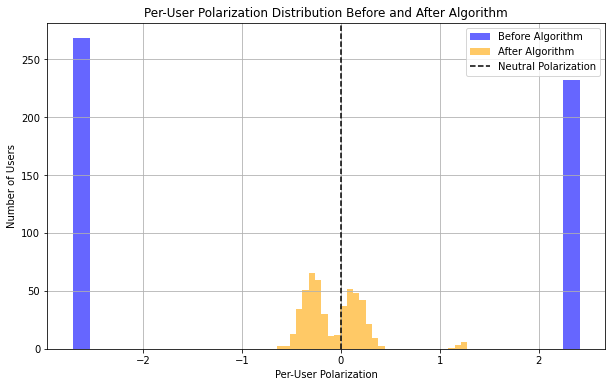

In [133]:
plt.figure(figsize=(10, 6))
plt.hist(initial_per_user_polarization, bins=30, alpha=0.6, label='Before Algorithm', color='blue')
plt.hist(per_user_polarization, bins=30, alpha=0.6, label='After Algorithm', color='orange')
plt.axvline(x=0, color='black', linestyle='--', label='Neutral Polarization')
plt.xlabel('Per-User Polarization')
plt.ylabel('Number of Users')
plt.title('Per-User Polarization Distribution Before and After Algorithm')
plt.legend()
plt.grid(True)
plt.show()


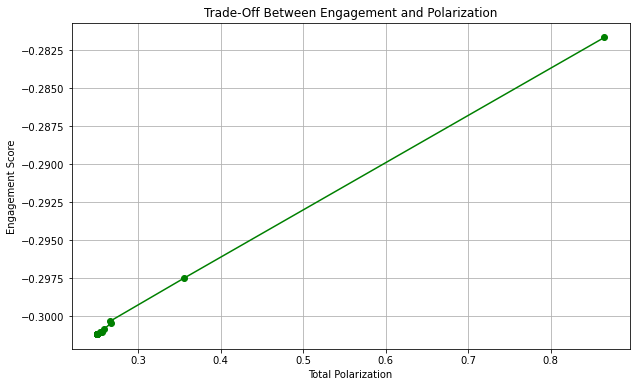

In [134]:
# Extract histories
iterations = results['iterations']
polarization_history = results['polarization_history']
engagement_history = results['engagement_history']
objective_history = results['objective_history']
kappa_history = results['kappa_history']


plt.figure(figsize=(10, 6))
plt.plot(polarization_history, engagement_history, marker='o', linestyle='-', color='green')
plt.xlabel('Total Polarization')
plt.ylabel('Engagement Score')
plt.title('Trade-Off Between Engagement and Polarization')
plt.grid(True)
plt.show()


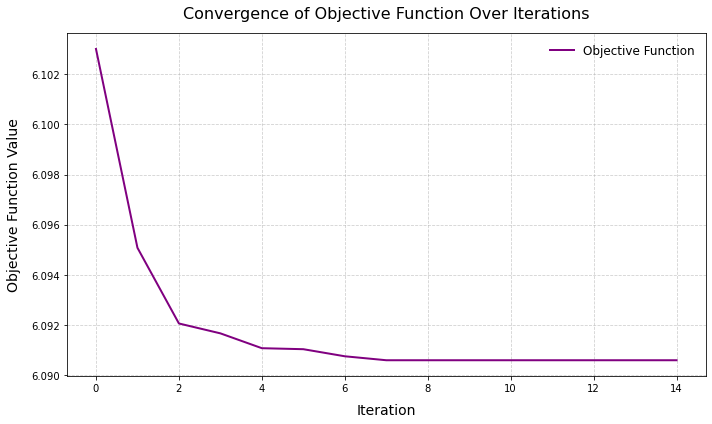

In [157]:
# Define formatting
line_color = 'purple'
line_width = 2

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(iterations, results['objective_history'], color=line_color, lw=line_width, label='Objective Function')

# Add labels and title
plt.xlabel('Iteration', fontsize=14, labelpad=10)
plt.ylabel('Objective Function Value', fontsize=14, labelpad=10)
plt.title('Convergence of Objective Function Over Iterations', fontsize=16, pad=15)

# Add legend
plt.legend(fontsize=12, loc='upper right', frameon=False)

# Add grid
plt.grid(visible=True, linestyle='--', alpha=0.6)

# Tight layout for better spacing
plt.tight_layout()

# Save the figure if needed
plt.savefig('Final images/objective_function_convergence.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

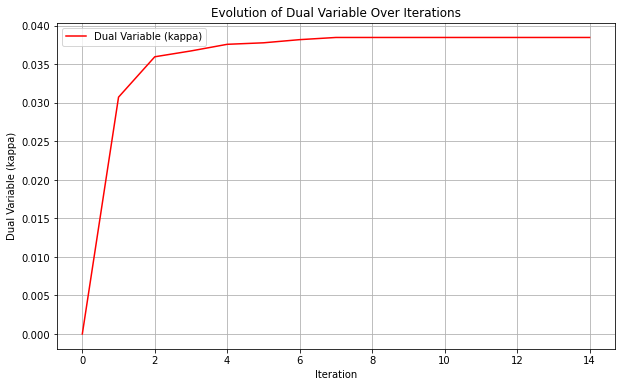

In [136]:
plt.figure(figsize=(10, 6))
plt.plot(iterations, results['kappa_history'], color='red', label='Dual Variable (kappa)')
plt.xlabel('Iteration')
plt.ylabel('Dual Variable (kappa)')
plt.title('Evolution of Dual Variable Over Iterations')
plt.legend()
plt.grid(True)
plt.show()


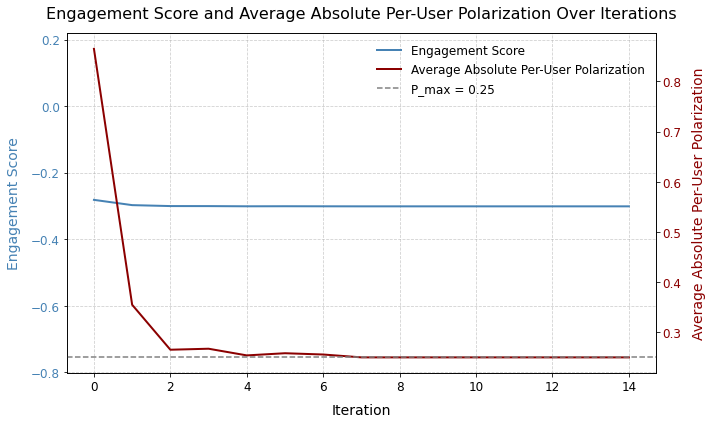

In [149]:
import matplotlib.pyplot as plt

# Define formatting
engagement_color = 'steelblue'
polarization_color = 'darkred'
line_width = 2

# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Engagement Score
ax1.set_xlabel('Iteration', fontsize=14, labelpad=10)
ax1.set_ylabel('Engagement Score', fontsize=14, color=engagement_color, labelpad=10)
engagement_line, = ax1.plot(iterations, engagement_history, color=engagement_color, lw=line_width, label='Engagement Score')
ax1.tick_params(axis='y', labelcolor=engagement_color)
ax1.tick_params(axis='both', labelsize=12)
ax1.set_ylim([min(engagement_history) - 0.5, max(engagement_history) + 0.5])

# Plot Average Absolute Per-User Polarization on second axis
ax2 = ax1.twinx()
ax2.set_ylabel('Average Absolute Per-User Polarization', fontsize=14, color=polarization_color, labelpad=10)
polarization_line, = ax2.plot(iterations, polarization_history, color=polarization_color, lw=line_width, label='Average Absolute Per-User Polarization')
pmax_line = ax2.axhline(y=P_max, color='gray', linestyle='--', linewidth=1.5, label=f'P_max = {P_max:.2f}')
ax2.tick_params(axis='y', labelcolor=polarization_color)
ax2.tick_params(axis='both', labelsize=12)

# Combine legends in the top-right corner
lines = [engagement_line, polarization_line, pmax_line]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper right', fontsize=12, frameon=False)

# Add title and grid
plt.title('Engagement Score and Average Absolute Per-User Polarization Over Iterations', fontsize=16, pad=15)
ax1.grid(visible=True, linestyle='--', alpha=0.6)

# Tight layout for better spacing
fig.tight_layout()

# Save the figure if needed
plt.savefig('Final images/engagement_polarization_combined.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()



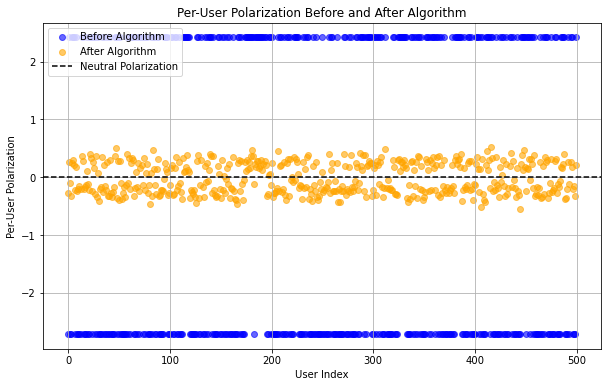

In [107]:
user_indices = np.arange(n_users)

plt.figure(figsize=(10, 6))
plt.scatter(user_indices, initial_per_user_polarization, alpha=0.6, label='Before Algorithm', color='blue')
plt.scatter(user_indices, per_user_polarization, alpha=0.6, label='After Algorithm', color='orange')
plt.axhline(y=0, color='black', linestyle='--', label='Neutral Polarization')
plt.xlabel('User Index')
plt.ylabel('Per-User Polarization')
plt.title('Per-User Polarization Before and After Algorithm')
plt.legend()
plt.grid(True)
plt.show()


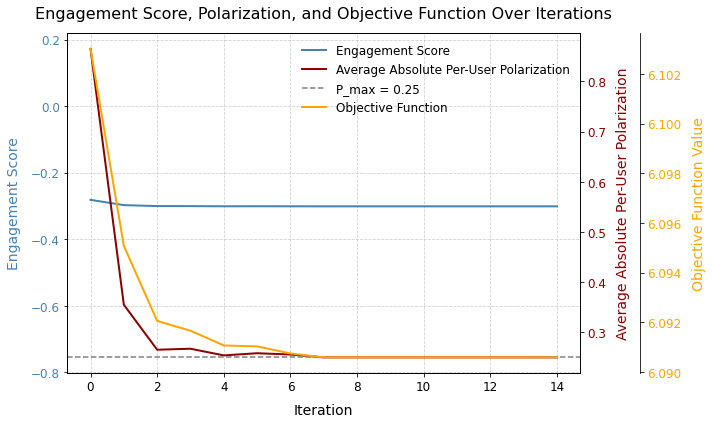

In [156]:
import matplotlib.pyplot as plt

# Define formatting
engagement_color = 'steelblue'
polarization_color = 'darkred'
objective_color = 'orange'
line_width = 2

# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Engagement Score
ax1.set_xlabel('Iteration', fontsize=14, labelpad=10)
ax1.set_ylabel('Engagement Score', fontsize=14, color=engagement_color, labelpad=10)
engagement_line, = ax1.plot(iterations, engagement_history, color=engagement_color, lw=line_width, label='Engagement Score')
ax1.tick_params(axis='y', labelcolor=engagement_color)
ax1.tick_params(axis='both', labelsize=12)
ax1.set_ylim([min(engagement_history) - 0.5, max(engagement_history) + 0.5])

# Plot Average Absolute Per-User Polarization on second axis
ax2 = ax1.twinx()
ax2.set_ylabel('Average Absolute Per-User Polarization', fontsize=14, color=polarization_color, labelpad=10)
polarization_line, = ax2.plot(iterations, polarization_history, color=polarization_color, lw=line_width, label='Average Absolute Per-User Polarization')
pmax_line = ax2.axhline(y=P_max, color='gray', linestyle='--', linewidth=1.5, label=f'P_max = {P_max:.2f}')
ax2.tick_params(axis='y', labelcolor=polarization_color)
ax2.tick_params(axis='both', labelsize=12)

# Add the Objective Function to the plot on a third axis
ax3 = ax1.twinx()
# Offset the third axis to avoid overlap
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel('Objective Function Value', fontsize=14, color=objective_color, labelpad=10)
objective_line, = ax3.plot(iterations, results['objective_history'], color=objective_color, lw=line_width, label='Objective Function')
ax3.tick_params(axis='y', labelcolor=objective_color)
ax3.tick_params(axis='both', labelsize=12)

# Combine legends in the top-right corner
lines = [engagement_line, polarization_line, pmax_line, objective_line]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper right', fontsize=12, frameon=False)

# Add title and grid
plt.title('Engagement Score, Polarization, and Objective Function Over Iterations', fontsize=16, pad=15)
ax1.grid(visible=True, linestyle='--', alpha=0.6)

# Tight layout for better spacing
fig.tight_layout()

# Save the figure if needed
plt.savefig('Final images/combined_plot.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

